In [ ]:
# Find out GPU allocated (P100s, T4 reccommended)
import tensorflow as tf
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
# Install art if absent
!pip install adversarial-robustness-toolbox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import fbfadvtrain
import activationsf

from activationsf import Kaf
from lr_finder import LRFinder

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, GlobalAveragePooling2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2 
from tensorflow.keras import Model
from tensorflow import math

regularizer = l2(0.0005)

In [ ]:
# Load CIFAR10
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
# Use tf.data to improve performances
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Data augmentation 
def normalize(img, label):
  img = tf.cast(img, tf.float32)
  return img/255.0, label
def augment(img, label):
  img, _ = normalize(img, label)
  img = tf.image.resize_with_crop_or_pad(img, 40, 40) # Pad evenly w/ four 0s pixels
  img = tf.image.random_flip_left_right(img) # Random horizontal flip
  img = tf.image.random_crop(img, [32, 32, 3]) # Randomly crop back to cifar dimensionality
  return img, label

# Create generator
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)
test = (
    test
    .shuffle(1000)
    .map(normalize, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)  

### Build Resnet


In [ ]:
def cifar_res_block(x, s, filters, activation, kaf=False): 
  """ 
    Residual Block
  """

  x_skip = x # this will be used for addition with the residual block

  # First convolution, feature space halves when s=2 
  x = Conv2D(filters, kernel_size=(3, 3), strides=(s, s), padding='same', kernel_regularizer = regularizer)(x)
  x = BatchNormalization()(x)
  if kaf is not False:
    x = Kaf(D = 20, conv = True, moving = False, ridge=tf.keras.activations.relu) (x)
  else:
    x = Activation(activation)(x)

  # Second convolution, no dimensionality reduction
  x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer = regularizer)(x)

  # Project to a lower feature space the residual too if there was a dim reduction during 1st conv
  if s > 1:
    x_skip = Conv2D(filters, kernel_size=(3, 3), strides=(s, s), padding='same', kernel_regularizer = regularizer)(x_skip)
  
  # Add the input
  x = Add()([x, x_skip])
  x = BatchNormalization()(x)
  if kaf is not False:
    x = Kaf(D = 20, conv = True, moving = False, ridge=tf.keras.activations.relu) (x)
  else:
    x = Activation(activation)(x)

  return x

In [ ]:
def resnet20(act = None, is_kaf = False):

  input = Input(shape=(32,32,3)) # padded cifar10 images size

  # Preparation Step
  x = Conv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer = regularizer)(input)
  x = BatchNormalization()(x)
  if is_kaf is not False:
    x = Kaf(D = 20, conv = True, moving = False, ridge = tf.keras.activations.relu) (x)
  else:
    x = Activation(act)(x)

  # 1st stage: filter size 16, keep feature map size 
  x = cifar_res_block(x, s=1, filters=16, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=16, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=16, activation = act, kaf = is_kaf)

  # 2nd stage: double filter size, half feature map size
  x = cifar_res_block(x, s=2, filters=32, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=32, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=32, activation = act, kaf = is_kaf)

  # 3rd stage: double filter size, half feature map size
  x = cifar_res_block(x, s=2, filters=64, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=64, activation = act, kaf = is_kaf)
  x = cifar_res_block(x, s=1, filters=64, activation = act, kaf = is_kaf)

  x = GlobalAveragePooling2D()(x)

  x = Dense(10, activation='softmax', kernel_initializer='he_normal', dtype=tf.float32, kernel_regularizer = regularizer)(x) 

  model = fbfadvtrain.FastBetterFreeTrainedModel(inputs=input, outputs=x, name='resnet') # Adv. Training Module

  return model

In [ ]:
# Learning rate range test
# Code from: https://github.com/beringresearch/lrfinder

BATCH = 128
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH)


resnet_20 = resnet20(is_kaf=True)
resnet_20.compile(
              optimizer = tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='sparse_categorical_accuracy'
              )

lr_finder = LRFinder(resnet_20)
lr_finder.find(train, start_lr=1e-4, end_lr=3, epochs=5,
               steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/5
391/391 [==============================] - 131s 335ms/step - loss: 2.7636 - sparse_categorical_accuracy: 0.0375
Epoch 2/5
391/391 [==============================] - 131s 335ms/step - loss: 2.7167 - sparse_categorical_accuracy: 0.0448
Epoch 3/5
391/391 [==============================] - 131s 335ms/step - loss: 2.5836 - sparse_categorical_accuracy: 0.1223
Epoch 4/5
391/391 [==============================] - 130s 334ms/step - loss: 2.3950 - sparse_categorical_accuracy: 0.2054
Epoch 5/5
391/391 [==============================] - 130s 334ms/step - loss: 2.2354 - sparse_categorical_accuracy: 0.2228


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    """
    Plots the loss.
    Parameters:
        n_skip_beginning - number of batches to skip on the left.
        n_skip_end - number of batches to skip on the right.
        """
    learning_rates = lr_finder.get_learning_rates()
    losses = lr_finder.get_losses()

    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

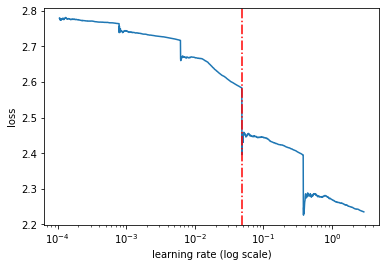

In [ ]:
axs = plot_loss()
axs.axvline(x=lr_finder.get_best_lr(sma=20), c='r', linestyle='-.')

In [ ]:
import tensorflow_addons as tfa

class schedulePlot(tf.keras.callbacks.Callback):

  def __init__(self):
    super(schedulePlot, self).__init__()
    self.lrs = []
    self.step = 0

  def on_train_batch_end(self, batch, logs=None):
    self.step += 1
    self.lrs.append(self.model.optimizer.lr(self.step))            

  def on_train_end(self, logs=None):
    plt.plot(self.lrs)
    plt.show()


epochs = 80
step_size = np.ceil((len(x_train) / 128) * (epochs/2))

oclr = tfa.optimizers.TriangularCyclicalLearningRate(initial_learning_rate = 0.01, maximal_learning_rate = 0.8, step_size = step_size)
# Sanity check, uncomment and add as callback to plot the evolution of lr throughout the training
# lrplot = schedulePlot() 

resnet_20.compile(
              optimizer = tf.keras.optimizers.SGD(learning_rate = oclr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='sparse_categorical_accuracy'
              )
resnet_20.fit(x = train, epochs = epochs, batch_size = 128, validation_data = test)


Epoch 1/80
391/391 [==============================] - 135s 346ms/step - loss: 2.5668 - sparse_categorical_accuracy: 0.1283 - val_loss: 2.4179 - val_sparse_categorical_accuracy: 0.2167
Epoch 2/80
391/391 [==============================] - 135s 346ms/step - loss: 2.3718 - sparse_categorical_accuracy: 0.2013 - val_loss: 2.2302 - val_sparse_categorical_accuracy: 0.3025
Epoch 3/80
391/391 [==============================] - 135s 345ms/step - loss: 2.3144 - sparse_categorical_accuracy: 0.2161 - val_loss: 2.1818 - val_sparse_categorical_accuracy: 0.3164
Epoch 4/80
391/391 [==============================] - 135s 345ms/step - loss: 2.2620 - sparse_categorical_accuracy: 0.2347 - val_loss: 2.1343 - val_sparse_categorical_accuracy: 0.3396
Epoch 5/80
391/391 [==============================] - 135s 346ms/step - loss: 2.1963 - sparse_categorical_accuracy: 0.2483 - val_loss: 2.0460 - val_sparse_categorical_accuracy: 0.3584
Epoch 6/80
391/391 [==============================] - 135s 346ms/step - loss: 2.

In [ ]:
# Store the model
resnet_20.save('/content/resnet20_kafs')
!zip -r resnet20_kafrelu_ocrob_lrfinder.zip ./resnet20_kafs
from google.colab import files
files.download('/content/resnet20_kafrelu_ocrob_lrfinder.zip')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/resnet20_kafs/assets
  adding: resnet20_kafs/ (stored 0%)
  adding: resnet20_kafs/variables/ (stored 0%)
  adding: resnet20_kafs/variables/variables.index (deflated 78%)
  adding: resnet20_kafs/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: resnet20_kafs/assets/ (stored 0%)
  adding: resnet20_kafs/saved_model.pb (deflated 92%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load robust model trained as in https://arxiv.org/abs/2001.03994
!unzip /content/resnet20_kafrelu_ocrob_lrfinder.zip
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate
model_path = '/content/resnet20_kafs'
model = tf.keras.models.load_model(model_path, custom_objects={'optimizer': TriangularCyclicalLearningRate})
model = fbfadvtrain.FastBetterFreeTrainedModel(inputs = model.input, outputs = model.output)

Archive:  /content/resnet20_kafrelu_ocrob_lrfinder.zip
   creating: resnet20_kafs/
   creating: resnet20_kafs/variables/
  inflating: resnet20_kafs/variables/variables.index  
  inflating: resnet20_kafs/variables/variables.data-00000-of-00001  
   creating: resnet20_kafs/assets/
  inflating: resnet20_kafs/saved_model.pb  


In [ ]:
# Last phase implementation of the OC learning policy
# lr_min = lr_max/(25 * 100)
def lr_schedule(epoch, lr):
  if epoch % 4 == 0:
    lr = lr / 2
  else:
    lr = lr
  return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
model.compile(
              optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='sparse_categorical_accuracy'
              )
model.fit(x = train, epochs = 20, batch_size = 128, validation_data = test, callbacks=[lr_callback])

Epoch 1/20
391/391 [==============================] - 92s 235ms/step - loss: 0.9474 - sparse_categorical_accuracy: 0.5865 - val_loss: 0.7639 - val_sparse_categorical_accuracy: 0.7904
Epoch 2/20
391/391 [==============================] - 91s 234ms/step - loss: 0.9441 - sparse_categorical_accuracy: 0.5884 - val_loss: 0.7584 - val_sparse_categorical_accuracy: 0.7937
Epoch 3/20
391/391 [==============================] - 92s 234ms/step - loss: 0.9398 - sparse_categorical_accuracy: 0.5870 - val_loss: 0.7563 - val_sparse_categorical_accuracy: 0.7926
Epoch 4/20
391/391 [==============================] - 91s 234ms/step - loss: 0.9385 - sparse_categorical_accuracy: 0.5887 - val_loss: 0.7560 - val_sparse_categorical_accuracy: 0.7935
Epoch 5/20
391/391 [==============================] - 91s 234ms/step - loss: 0.9353 - sparse_categorical_accuracy: 0.5897 - val_loss: 0.7539 - val_sparse_categorical_accuracy: 0.7942
Epoch 6/20
391/391 [==============================] - 91s 234ms/step - loss: 0.9321 -

In [ ]:
# Store the model
model.save('/content/resnet20_kafs')
!zip -r resnet20_kafrelu_ocrob_lrfinder.zip ./resnet20_kafs
from google.colab import files
files.download('/content/resnet20_kafrelu_ocrob_lrfinder.zip')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/resnet20_kafs/assets
  adding: resnet20_kafs/ (stored 0%)
  adding: resnet20_kafs/assets/ (stored 0%)
  adding: resnet20_kafs/saved_model.pb (deflated 92%)
  adding: resnet20_kafs/variables/ (stored 0%)
  adding: resnet20_kafs/variables/variables.index (deflated 78%)
  adding: resnet20_kafs/variables/variables.data-00000-of-00001 (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>